In [1]:
import os.path
from os import path
import pandas as pd


# 캐글 ↓제출경로
data_path = '/kaggle/input/bike-sharing-demand/'
if not path.exists(data_path):
    data_path = './input/'
print(f'input directory path : {data_path}')

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

print(f'train shape : {train.shape}')
print(f'test_shape : {test.shape}')

# 날씨 weather ==> 4 인것 제거,
train = train[train['weather'] != 4]

# train 과 test 데이터 합치기 (index 역시 합쳐야 한다.)

all_data = pd.concat([train, test], ignore_index=True)
all_data

from datetime import datetime

# 날짜 피처 생성
all_data['date'] = all_data['datetime'].apply(lambda x : x.split()[0])

# 연도 피처
all_data['year'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[0])

# 월피처
all_data['month'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[1])

# 시 피처 생성
all_data['hour'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[0])

# 요일 피처 생성
all_data['weekday'] = all_data['date'].apply(lambda dateString : datetime.strptime(dateString, "%Y-%m-%d").weekday())

# 훈련데이터 매달 1일~19일, 테스트 데이터 매달 20일~ 이므로 day 사용필요 x 
# minute, second 역시 사용필요 x (상식적)
all_data.head()


# all_data['datetime'] = pd.to_datetime(all_data['datetime'])
# all_data['year'] = all_data['datetime'].dt.year , dt.month, dt.hour, dt.weekday 로 변경가능


# 필요 없는 피처 제거

# 1. casual 과 registered 피처는 테스트 데이터 에 없는 피처이므로 제거
# 2. datetime 피처는  date(year,month,day) 피처가 가지고 있기에 필요 x
# 3. season 피처가 month 대분류이기에 month 제거
# 4. windspeed 상관관계 약하기에 제거 한다 

drop_features = ['casual', 'registered', 'datetime', 'date', 'month', 'windspeed']
all_data = all_data.drop(drop_features, axis=1)

all_data

# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

# 타깃값 count 제거
X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

y = train['count'] # 타깃값 

X_train.head()

# 테스트 데이터 왜있는지....
# 평가 지표 계싼 함수 작성

import numpy as np

def rmsle(y_true, y_pred, convertExp=True):
    # 지수변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    # RMSLE 계산
    output = np.sqrt(np.mean((log_true -log_pred)**2))
    return output

input directory path : ./input/
train shape : (10886, 12)
test_shape : (6493, 9)


In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# 모델 생성
randomforest_model = RandomForestRegressor()
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

# 그리드서치 객체 생성
rf_params = {'random_state': [42], 'n_estimators': [100, 120, 140,160,200]} #
gridsearch_random_forest_model = GridSearchCV(
    estimator=randomforest_model,
    param_grid=rf_params,
    scoring=rmsle_scorer,
    cv=5
)

# 그리드서치 수행
log_y = np.log(y)
gridsearch_random_forest_model.fit(X_train, log_y)
print('최적 하이퍼파라미터 : ', gridsearch_random_forest_model.best_params_)

# 모델 성능 검증 및 예측
preds = gridsearch_random_forest_model.best_estimator_.predict(X_train)
# 평가
print(f'랜덤 포레스트 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

최적 하이퍼파라미터 :  {'n_estimators': 160, 'random_state': 42}
랜덤 포레스트 회귀 RMSLE 값 : 0.1124


Text(0.5, 1.0, 'Predicted Test Data Distribution')

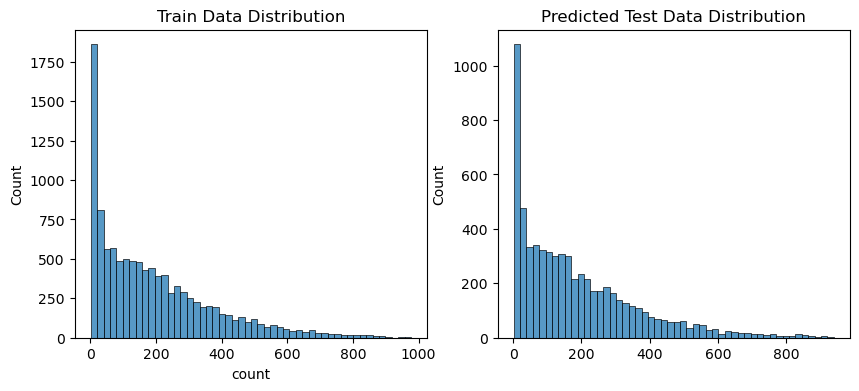

In [3]:
# 예측 및 결과 예측
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

randomforest_preds = gridsearch_random_forest_model.best_estimator_.predict(X_test)

figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(10, 4)

sns.histplot(y, bins=50, ax=axes[0])
axes[0].set_title('Train Data Distribution')
sns.histplot(np.exp(randomforest_preds), bins=50, ax=axes[1])
axes[1].set_title('Predicted Test Data Distribution')

In [4]:
# 결과 제출 

submission['count'] = np.exp(randomforest_preds) # 지수변환


if data_path == "./input/":
    submission.to_csv('./output/'+'submission.csv', index=False)
else:
    submission.to_csv('submission.csv',index=False)